In [29]:
import numpy as np
from sklearn import preprocessing, model_selection, neighbors
import pandas as pd
import os
from PIL import Image

#Datos obtenidos de https://www.kaggle.com/datasets/sanikamal/horses-or-humans-dataset

In [30]:
#Cargamos las rutas de los conjuntos de las imágenes

train_dir = os.path.join("C:/Users/Enrique Marín/Documents/Inteligencia Artificial/Entrega final/horse-or-human/train/")
test_dir = os.path.join("C:/Users/Enrique Marín/Documents/Inteligencia Artificial/Entrega final/horse-or-human/validation/")

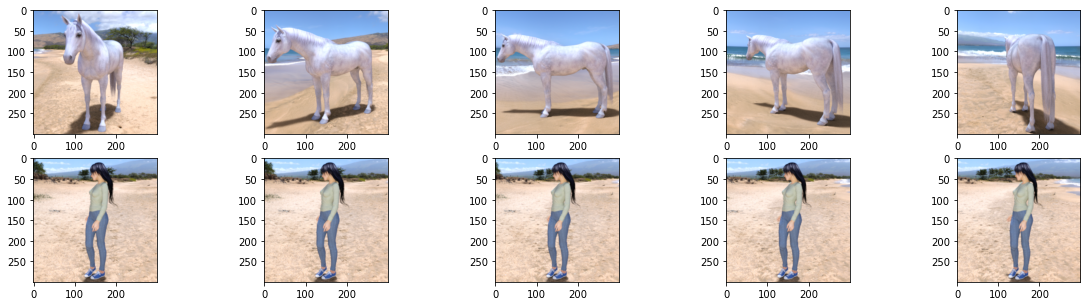

In [31]:
#Visualizamos una pequeña muestra de las imágenes

horse_imgs = []
human_imgs = []

for i in range(5):
    horse_im = Image.open(os.path.join("horse-or-human/train/horses",
                                       os.listdir("horse-or-human/train/horses")[i]))
    human_im = Image.open(os.path.join("horse-or-human/train/humans",
                                       os.listdir("horse-or-human/train/humans")[i]))
    horse_imgs.append(horse_im)
    human_imgs.append(human_im)
    

plt.rcParams["figure.figsize"] = (20,5)
fig, axs = plt.subplots(2, 5)
for i in range(2):
    for j in range(5):
        if i == 0:
            axs[i, j].imshow(horse_imgs[j])
        else:
            axs[i, j].imshow(human_imgs[j])
plt.show()

In [32]:
#Modificamos las imágenes para mejorar la precisión de nuestro modelo y las dividimos en train y validation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

def image_gen_w_aug(train_parent_directory, test_parent_directory):
    
    train_datagen = ImageDataGenerator(rescale=1/255,
                                      rotation_range = 40,  
                                      zoom_range = 0.3, 
                                      width_shift_range=0.3,  
                                      height_shift_range=0.2,
                                      validation_split = 0.2)
    
  
    
    test_datagen = ImageDataGenerator(rescale=1/255)
    
    train_generator =          train_datagen.flow_from_directory(train_parent_directory,
                                  target_size = (75,75),
                                  batch_size = 87,
                                  class_mode = 'categorical',
                                  subset='training')
    
    val_generator = train_datagen.flow_from_directory(train_parent_directory,
                                  target_size = (75,75),
                                  batch_size = 15,
                                  class_mode = 'categorical',
                                  subset = 'validation')
    
    test_generator = test_datagen.flow_from_directory(test_parent_directory,
                                 target_size=(75,75),
                                 batch_size = 25,
                                 class_mode = 'categorical')
    return train_generator, val_generator, test_generator

In [33]:
train_generator, validation_generator, test_generator = image_gen_w_aug(train_dir, test_dir)

Found 822 images belonging to 2 classes.
Found 205 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [34]:
#Para el modelos usamos InceptionV3 (una red neuronal convolucional para ayudar en
#el análisis de imágenes y la detección de objetos, y comenzó como un módulo para Googlenet)

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Flatten, Dense, Dropout
import tensorflow as tf

def model_output_for_TL (pre_trained_model, last_output):    
    x = Flatten()(last_output)
    
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    x = Dense(2, activation='softmax')(x)
    
    model = tf.keras.Model(pre_trained_model.input, x)
    
    return model

pre_trained_model = InceptionV3(input_shape = (75, 75, 3), 
                                include_top = False, 
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed5')
last_output = last_layer.output
modelo = model_output_for_TL(pre_trained_model, last_output)

In [35]:
#Vemos un resumen de las capas que va a tener nuestro modelo

modelo.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_94 (Conv2D)             (None, 37, 37, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 37, 37, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_94 (Activation)     (None, 37, 37, 32)   0           ['batch_normalization_94[0]

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_105 (Batch  (None, 7, 7, 32)    96          ['conv2d_105[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_99 (Activation)     (None, 7, 7, 64)     0           ['batch_normalization_99[0][0]'] 
                                                                                                  
 activation_101 (Activation)    (None, 7, 7, 64)     0           ['batch_normalization_101[0][0]']
                                                                                                  
 activation_104 (Activation)    (None, 7, 7, 96)     0           ['batch_normalization_104[0][0]']
          

                                                                                                  
 conv2d_117 (Conv2D)            (None, 7, 7, 96)     55296       ['activation_116[0][0]']         
                                                                                                  
 batch_normalization_114 (Batch  (None, 7, 7, 48)    144         ['conv2d_114[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_117 (Batch  (None, 7, 7, 96)    288         ['conv2d_117[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_114 (Activation)    (None, 7, 7, 48)     0           ['batch_normalization_114[0][0]']
          

 conv2d_128 (Conv2D)            (None, 3, 3, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_128 (Batch  (None, 3, 3, 128)   384         ['conv2d_128[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_128 (Activation)    (None, 3, 3, 128)    0           ['batch_normalization_128[0][0]']
                                                                                                  
 conv2d_129 (Conv2D)            (None, 3, 3, 128)    114688      ['activation_128[0][0]']         
                                                                                                  
 batch_normalization_129 (Batch  (None, 3, 3, 128)   384         ['conv2d_129[0][0]']             
 Normaliza

 activation_138 (Activation)    (None, 3, 3, 160)    0           ['batch_normalization_138[0][0]']
                                                                                                  
 conv2d_139 (Conv2D)            (None, 3, 3, 160)    179200      ['activation_138[0][0]']         
                                                                                                  
 batch_normalization_139 (Batch  (None, 3, 3, 160)   480         ['conv2d_139[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_139 (Activation)    (None, 3, 3, 160)    0           ['batch_normalization_139[0][0]']
                                                                                                  
 conv2d_135 (Conv2D)            (None, 3, 3, 160)    122880      ['mixed4[0][0]']                 
          

__________________________________________________________________________________________________


In [36]:
#Generamos nuestro modelo

modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = modelo.fit(
      train_generator,
      epochs=20,
      steps_per_epoch=5,
      verbose=1,
      validation_data = validation_generator)

Epoch 1/20
5/5 [==============================] - 8s 1s/step - loss: 6.7087 - accuracy: 0.5013 - val_loss: 3.3902 - val_accuracy: 0.5122
Epoch 2/20
5/5 [==============================] - 5s 987ms/step - loss: 1.5055 - accuracy: 0.6069 - val_loss: 0.7286 - val_accuracy: 0.5268
Epoch 3/20
5/5 [==============================] - 5s 976ms/step - loss: 0.6102 - accuracy: 0.6552 - val_loss: 0.5253 - val_accuracy: 0.7171
Epoch 4/20
5/5 [==============================] - 4s 985ms/step - loss: 0.4617 - accuracy: 0.7984 - val_loss: 0.4386 - val_accuracy: 0.7659
Epoch 5/20
5/5 [==============================] - 4s 931ms/step - loss: 0.2882 - accuracy: 0.8941 - val_loss: 0.3727 - val_accuracy: 0.8439
Epoch 6/20
5/5 [==============================] - 5s 988ms/step - loss: 0.2427 - accuracy: 0.8989 - val_loss: 0.3294 - val_accuracy: 0.8585
Epoch 7/20
5/5 [==============================] - 4s 992ms/step - loss: 0.2019 - accuracy: 0.9328 - val_loss: 0.2533 - val_accuracy: 0.9073
Epoch 8/20
5/5 [=======

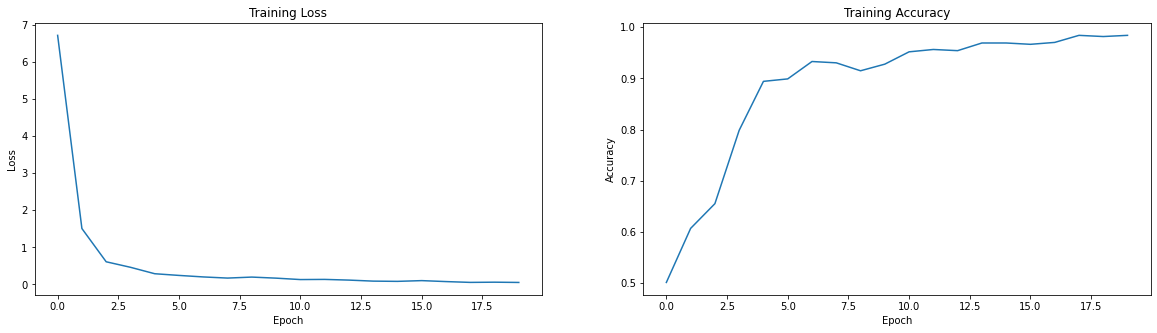

In [37]:
#Vemos como mejora el modelo cuanto más iteraciones ponemos

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)

axs[0].plot(history.history['loss'])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(history.history['accuracy'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training Accuracy')

plt.show()

In [38]:
#Exportamos nuestro modelo para poder usarlo en nuestra webapp con streamlit
tf.keras.models.save_model(model_TL,'modeloCabHumV3.hdf5')